# EE 467 Lab 3: Dimensionality Reduction and Visualization

Starting with lab 3, we will move on to two classes of unsupervised machine learning algorithms-dimensionality reduction and clustering. These algorithms can help us figure out previously unknown patterns in the features without any kind of labels. We will apply these algorithms to the KDD Cup 1999 network intrusion dataset and visualize their results. These results may reflect differences in the characteristics of malicious and normal network connections from an alternative perspective.

## Dataset

We will work on the KDD Cup 1999 network intrusion dataset for this lab. The KDD Cup 1999 dataset consists of approximately 4.9 million records of network connections. Here a connection is a sequence of TCP packets starting and ending at some well defined times, during which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The original goal of the contest is to predictive model (i.e. a classifier) capable of distinguishing between malicious connections, called intrusions or attacks, and good normal connections.

Attacks in the KDD Cup 1999 dataset fall into four main categories:

1. DoS: Denial-of-service attacks, e.g. syn flood.
2. R2L: Unauthorized access from a remote machine, e.g. password guessing.
3. U2R: Unauthorized access to local superuser (root) privileges, e.g. privilege escalation through buffer overflow attacks.
4. Probing: surveillance and other probing, e.g. port scanning.

## Pre-processing

The KDD cup 1999 network intrusion dataset is huge (~743M) and is way too much to demostrate dimensionality reduction and data visualization. As such, we use a reduced dataset that only contains 10% of the original data. As usual, we load the dataset into memory and preview a few records of the dataset:

In [2]:
import pandas as pd

# Column names for KDD Cup 1999 dataset
all_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load dataset with Pandas
kdd_data_10p = pd.read_csv("./kddcup.data_10_percent_corrected", names=all_columns)
# Preview a few records
kdd_data_10p.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


We can also show statistics (such as mean, median, standard deviation etc.) of each column:

In [3]:
# Show statistics of the dataset
kdd_data_10p.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


But we are probably more interested in the categories and frequencies of different attacks:

In [4]:
# Show the categories and frequencies of different attacks
kdd_data_10p["label"].value_counts()

label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

## Feature Extraction

Now that we have loaded the dataset, we can observe two kinds of columns: some columns, such as `src_bytes` and `dst_bytes`, are numerical; some others, like `label`, are categorical, in that there is only a limited number of possible values for them. For dimensionality reduction, we are not considering categorical columns as part of the features for now, as they require special processing. The following code extracts numerical features from the dataset:

In [5]:
# All categorical columns
categorical_columns = ["protocol_type", "service", "flag", "label"]

# Extract numerical columns only and convert DataFrame to float type
kdd_features = kdd_data_10p.copy()

for column in categorical_columns:
    del kdd_features[column]

# Preview a few records
kdd_features.head(10)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,181,5450,0,0,0,0,0,1,0,...,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0
1,0,239,486,0,0,0,0,0,1,0,...,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0
2,0,235,1337,0,0,0,0,0,1,0,...,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
3,0,219,1337,0,0,0,0,0,1,0,...,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
4,0,217,2032,0,0,0,0,0,1,0,...,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0
5,0,217,2032,0,0,0,0,0,1,0,...,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0
6,0,212,1940,0,0,0,0,0,1,0,...,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0
7,0,159,4087,0,0,0,0,0,1,0,...,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0
8,0,210,151,0,0,0,0,0,1,0,...,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0
9,0,212,786,0,0,0,1,0,1,0,...,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0


Next, we need to perform **feature scaling** on our features. Notice that for each column, the mean and variance (and thus the distribution) of the data is different from others, causing the unit of each dimension to been different. This poses problems for unsupervised learning algorithms as they treat all dimensions to be equal so that they can compute the distance between samples. Here we will try two ways to solve the problem.

The first solution, in which we use `MinMaxScaler`, rescales data of each dimension proportionally to $[0, 1]$ by performing the following transformation:

$$
x_{minmax} = \frac{x-\min(x)}{\max(x)-\min(x)}
$$

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Features obtained from `MinMaxScaler`
kdd_feat_minmax = pd.DataFrame()

## [ TODO ]
# For each column in `kdd_features`
for col_name in kdd_features.columns:
    # 1) Convert column data to NumPy array and add an extra dimension
    col_data = kdd_features[col_name].values.astype(float)[:, None]
    # 2) Re-scale data with `MinMaxScaler`
    col_scaled = MinMaxScaler().fit_transform(col_data)
    # 3) Update column with scaled result
    kdd_feat_minmax[col_name] = col_scaled.squeeze()

# Convert features to NumPy array
kdd_feat_minmax = kdd_feat_minmax.values

The second solution, in which we use `StandardScaler` instead, de-mean each dimension by subtracting the average value from original data, and then re-scale data by the standard deviation of the original data:

$$
x_{std} = \frac{x - \overline{x}}{std(x)}
$$

However, as you will see later, just re-scale data with `StandardScaler` isn't enough as the `StandardScaler` features doesn't look good with dimensionality reduction algorithms. A few **outliers** cause the majority of samples to be visualized on the same side of the graph, which is not helpful for showing the distribution of samples. (Why?)

To avoid outliers from affecting the plot of dimensionality reduction, we can detect and remove them in advance. How can we remove connections with at least one dimension with outlier data?

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Features obtained from `StandardScaler`
kdd_feat_std = pd.DataFrame()

# Remove outliers for `StandardScaler`
remove_outliers = True
# Outlier threshold (standard deviation as unit)
outlier_threshold = 10
# Indices of records with outlier values
outlier_indices = set()

for col_name in kdd_features.columns:
    # Obtain column data as 2D NumPy array
    col_data = kdd_features[col_name].values.astype(float)[:, None]
    # Re-scale data with `StandardScaler`
    col_data = StandardScaler().fit_transform(col_data)

    if remove_outliers:
        # 1) Get indices of records with outlier column values
        bad = np.where(np.abs(col_data.squeeze()) > outlier_threshold)[0]
        # 2) Merge these indices with `outlier_indices`
        outlier_indices.update(bad.tolist())

    # Copy rescaled column
    kdd_feat_std[col_name] = col_data.squeeze()

# Remove records with outlier values
if remove_outliers and len(outlier_indices) > 0:
    kdd_feat_std = kdd_feat_std.drop(index=sorted(outlier_indices))

# Convert features to NumPy array
kdd_feat_std = kdd_feat_std.values

We will also attach labels for these samples. For this lab we only care about whether a connection is "malicious" (associated with an attack) or not, so we convert the labels column to either 0 (for normal connection) or 1 (for connection associated with an attck):

In [9]:
# Convert labels to 0 for normal connection and 1 for connection associated with attack
y = (kdd_data_10p["label"] != "normal.").astype(int)

# Numerical labels for `MinMaxScaler` features
y_minmax = y.values

# Numerical labels for `StandardScaler` features
y_std = y
# Removing labels for samples with outlier data for consistency
if remove_outliers and len(outlier_indices) > 0:
    y_std = y.drop(index=sorted(outlier_indices))

# Convert labels to NumPy array
y_std = y_std.values

To reduce the execution time of dimenionality reduction algorithms, we will only work on a very small portion of samples (5% of the 10% dataset, or in other words, 0.5% of the original data). This is fine as we are mainly demostrating the usage and effects of these algorithms:

In [10]:
from sklearn.model_selection import train_test_split

# Further select only 5% of the samples for `MinMaxScaler` features
kdd_feat_minmax, _, y_minmax, _ = train_test_split(
    kdd_feat_minmax, y_minmax, train_size=0.05, random_state=12345678
)

# Further select only 5% of the samples for `StandardScaler` features
kdd_feat_std, _, y_std, _ = train_test_split(
    kdd_feat_std, y_std, train_size=0.05, random_state=12345678
)

## Dimensionality Reduction

In data mining and analysis, we often work with sparse, high-dimensional features. There are mainly two problems when directly applying traditional machine learning algorithms to these features: excessive computation power and memory requirements, and failure of learning effectively on such features. Dimensionality reduction algorithms solve these issues by transforming sparse, high-dimensional features into a lower-dimensional space where features are compactly distributed and represented. It also makes features much more intuitive by reducing them to a 2D (or 3D) space, which is much easier to handle for human brains.

Before showcasing the effects of dimensionality reduction algorithms, we need a function to visualize transformed features. In the `visualize_samples` function below, we will draw all transformed features on both a 2D and a 3D plot. We will plot normal connection features as green dots and malicious connection features as orange dots:

Figure(2000x500)


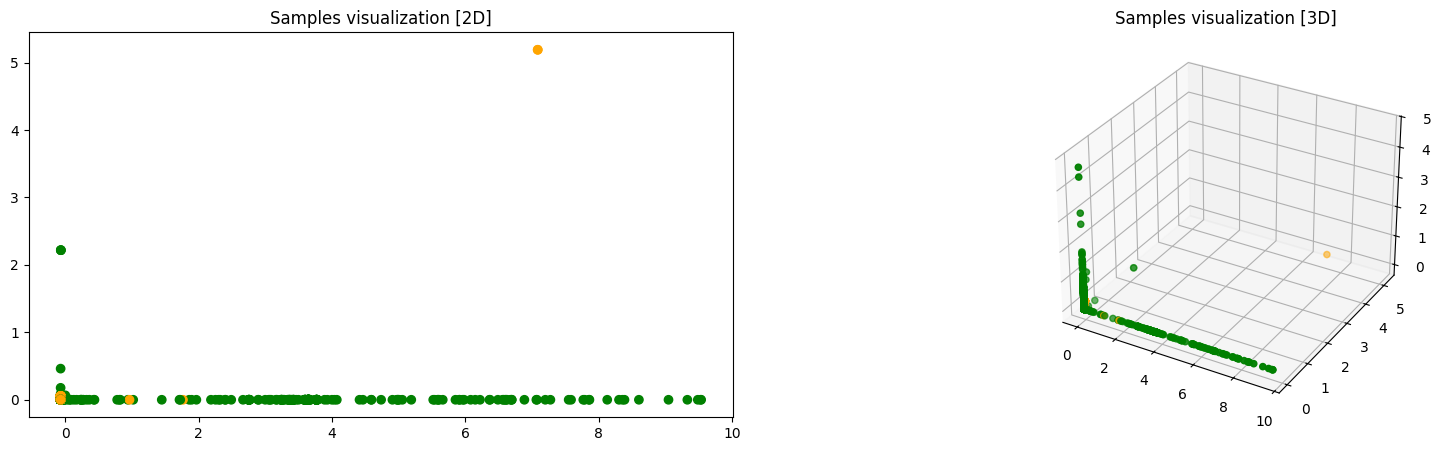

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_samples(samples, labels, title="Samples visualization", colors=["green", "orange"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(20, 5))

    # Plot first two dimensions on a 2D plot
    ax_2d = fig.add_subplot(1, 2, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels])

    # Plot first three dimensions on a 3D plot
    ax_3d = fig.add_subplot(1, 2, 2, projection="3d")
    ax_3d.set_title(f"{title} [3D]")
    ax_3d.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=colors[labels])

    print(fig)

# Visualize `StandardScaler` features (without dimensionality reduction)
visualize_samples(kdd_feat_std, y_std)

We will also use the following `timeit` function to monitor the training time of each algorithm:

In [12]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()

    # Execute task
    yield

    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.2f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.00s


### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a simple yet powerful technique used for dimensionality reduction. It is based on Singular Value Decomposition (SVD) of a matrix. Suppose matrix $\mathbf{M}$ of shape $m \times n$ represents $n$-dimensional features of $m$ samples, then according to SVD it can be decomposed into:

$$
\mathbf{M} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^*
$$

<div style="margin-top: 10px;">
    <img src="attachment:svd.png" width="25%" />
</div>

Where $\mathbf{U}$ is of shape $m \times m$ and its columns are called left singular vectors. Similarly, $\mathbf{V}^*$ is of shape $n \times n$ and its rows are called right singular vectors. $\mathbf{\Sigma}$ is a diagonal matrix of shape $m \times n$ and its diagonal elements are called singular values. For convenience reasons, here we call the $i$-th left and right singular vectors as well as corresponding singular value the $i$-th component.

To reduce the dimension of matrix $\mathbf{M}$, we first reorder $\mathbf{U}$, $\mathbf{\Sigma}$ and $\mathbf{V}^*$ by the singular value of each component, which can be seen as the "importance" of each component for the original data. Then, we truncate $\mathbf{U}$, $\mathbf{\Sigma}$ and $\mathbf{V}^*$ such that only the first $k (k < n)$ components are preserved. This gives as $\mathbf{U'}$ of shape $m \times k$, $\mathbf{\Sigma'}$ of shape $k \times k$ and $\mathbf{V'}^*$ of shape $k \times n$. Then, the result of PCA is given by:

$$
\mathbf{M'} = \mathbf{U'} \sqrt{\mathbf{\Sigma}}
$$

Below is the visualization of PCA result on two-dimensional data. The arrow shows the two components of PCA and the relative length of the arrow indicates the "importance" of each component:

<div style="margin-top: 10px;">
    <img src="attachment:pca-example.png" width="50%" />
</div>

Now, we will perform regular PCA on the `StandardScaler` features we have generated above. Note here we use `IncrementalPCA` rather than `PCA` for faster training, but the result should be roughly the same:

Regular PCA (IncrementalPCA) started...
Regular PCA (IncrementalPCA) completed. Elapsed time: 0.11s
Figure(2000x500)


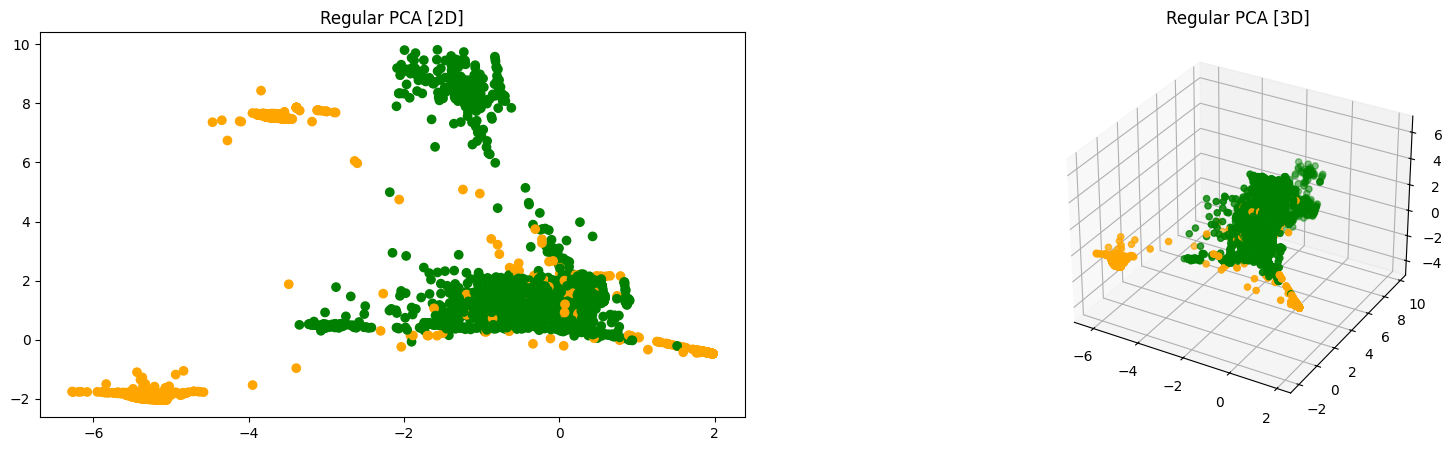

In [13]:
from sklearn.decomposition import IncrementalPCA

# Perform regular PCA on `kdd_feat_std`
pca = IncrementalPCA(n_components=3, batch_size=2048)
with timeit("Regular PCA (IncrementalPCA)"):
    kdd_feat_pca = pca.fit_transform(kdd_feat_std)

# Plot regular PCA result
visualize_samples(kdd_feat_pca, y_std, title="Regular PCA")

### Kernel PCA

Before talking about kernel PCA, we need to introduce kernel method. Here is a simple introduction of kernel method:

> ... With kernel functions, we implictly map sample features (represented as points) into a higher-dimensional space, where the inner product of transformed sample features can be efficiently computed using the kernel function. Kernel method can be used in conjunction with linear regression algorithm or its varients to deal with non-linear mapping. It can also be used with SVM to make sample features linear serapable in an alternative space.

Like kernel SVM, in kernel PCA we implicitly map sample features into a higher-dimensional alternative space. This might sound contradictive to the purpose of dimensionality reduction, but what we want to achieve here is similar to the SVM case: to make transformed features linear separable. Then, we will perform PCA on transformed features to bring the number of dimensions down. Compared with regular PCA, this might separate features from different classes better and make visualization more intuitive.

<div>
    <img src="attachment:kernel-svm.png" width="50%" />
</div>

For kernel PCA (and all other kernel-based algorithms), the kernel functions are usually non-linear functions and must satisfy [Mercer's Theorm](https://en.wikipedia.org/wiki/Mercer%27s_theorem), which requires them to be symmetric positive-semidefinite functions. Here we introduce a few common kernel functions:

* Polynomial kernel: suppose we have two sample vector $\mathbf{x}$ and $\mathbf{y}$, then the polynomial kernel function $K(\mathbf{x}, \mathbf{y})$ is defined as:

$$
K(\mathbf{x}, \mathbf{y}) = (\mathbf{x}^T \mathbf{y} + c)^d
$$

Where $c \ge 0$ is a constant controlling the influence of each dimension and $d$ determines number of dimension of the transformed space.

* Radial basis function (RBF) kernel: the radial basis function kernel is defined as:

$$
K(\mathbf{x}, \mathbf{y}) = \exp(\frac{-||\mathbf{x} - \mathbf{y}||_2^2}{2 \sigma^2})
$$

Where $\sigma$ is a hyper-parameter. RBF kernel corresponds to an infinite-dimensional transformed space.

* Sigmoid kernel: the sigmoid kernel is defined as:

$$
K(\mathbf{x}, \mathbf{y}) = \tanh(\mathbf{x}^T \mathbf{y} + c)
$$

Where $c \ge 0$ is a constant controlling the influence of each dimension. Like RBF kernel, sigmoid kernel also corresponds to infinite-dimensional transformed space.

This time, let's try kernel PCA on the `MinMaxScaler` features instead. We will use different kernel functions and also try a few hyper-parameter settings for each kernel function type:

Kernel PCA (Polynomial; d = 3) started...
Kernel PCA (Polynomial; d = 3) completed. Elapsed time: 29.49s
Kernel PCA (Polynomial; d = 6) started...
Kernel PCA (Polynomial; d = 6) completed. Elapsed time: 30.27s
Figure(2000x500)
Figure(2000x500)


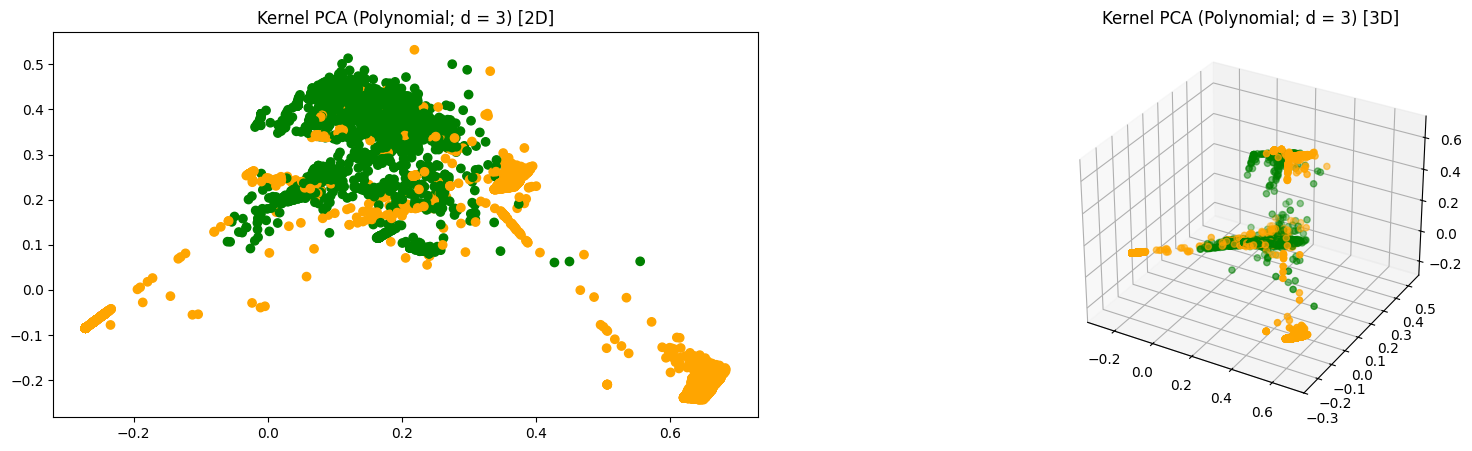

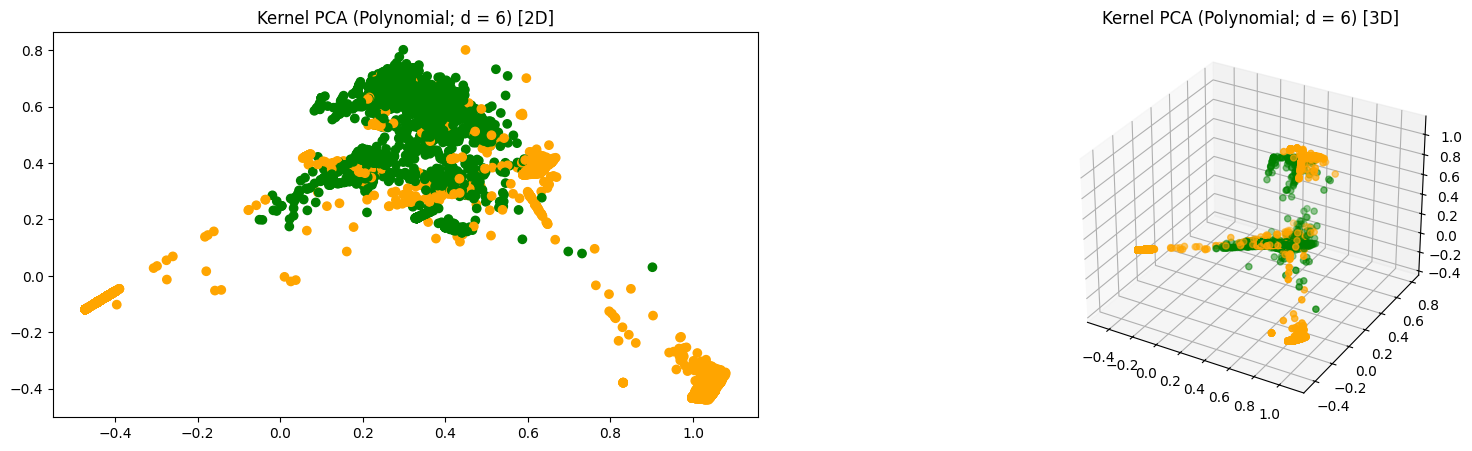

In [15]:
from sklearn.decomposition import KernelPCA

# Polynomial Kernel PCA (d = 3)
pca_poly_3 = KernelPCA(n_components=3, kernel="poly")
with timeit("Kernel PCA (Polynomial; d = 3)"):
    kdd_feat_pca_poly_3 = pca_poly_3.fit_transform(kdd_feat_minmax)

# Try a larger `d` for polynomial kernel (e.g. `d > 5`)
pca_poly_6 = KernelPCA(n_components=3, kernel="poly", degree=6)
with timeit("Kernel PCA (Polynomial; d = 6)"):
    kdd_feat_pca_poly_6 = pca_poly_6.fit_transform(kdd_feat_minmax)

# Plot kernel PCA result
visualize_samples(kdd_feat_pca_poly_3, y_minmax, title="Kernel PCA (Polynomial; d = 3)")
visualize_samples(kdd_feat_pca_poly_6, y_minmax, title="Kernel PCA (Polynomial; d = 6)")

### t-distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction algorithm that works well on visualizing high-dimensional, non-linear features. It is widely applied in image processing, natural language processing (NLP), genomic data and speech recognition. Roughly speaking, t-SNE models the distribution of neighbors for each feature in the high-dimensional space as a Gaussian distribution. It then tries to find a t-distribution in the target, low-dimensional space that resembles the high-dimensional one as much as possible. Finally, t-SNE random places target features in the low-dimensional space, such that their pairwise distances conform to the t-distribution solved above. You can take a look at the references if you are interested in the details of the algorithm.

For t-SNE, we will run it on the `StandardScaler` features and see if it can visualize features better than PCA. We will also try different perplexity values, which control how many nearest neighbors are used to model the neighbor Gaussian distribution.

t-SNE (Perplexity = 80) started...
t-SNE (Perplexity = 80) completed. Elapsed time: 770.50s
t-SNE (Perplexity = 30) started...
t-SNE (Perplexity = 30) completed. Elapsed time: 1450.63s
Figure(2000x500)
Figure(2000x500)


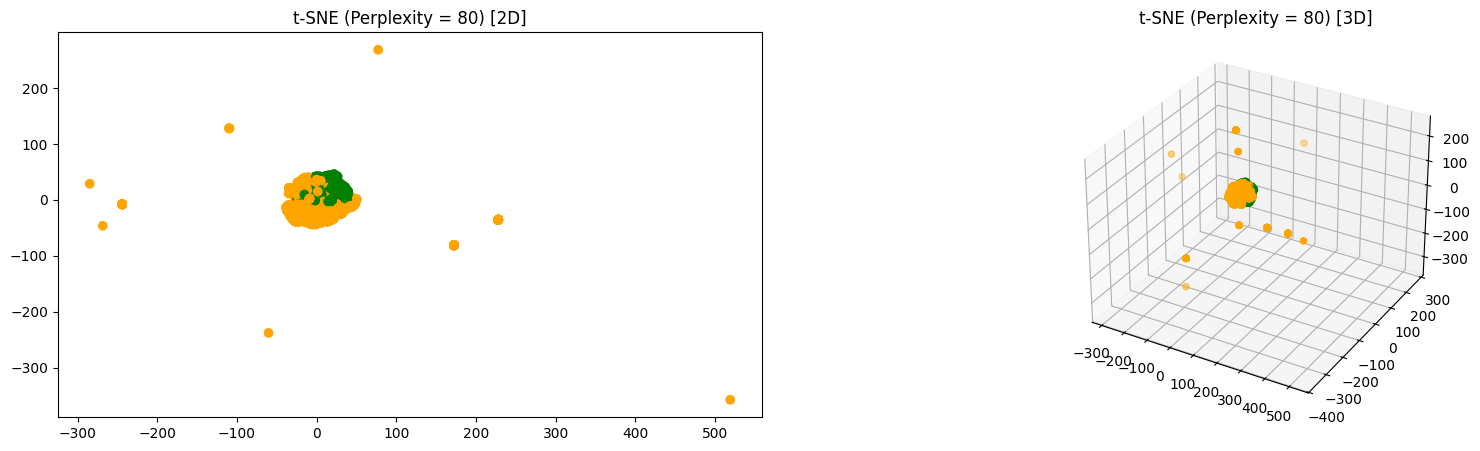

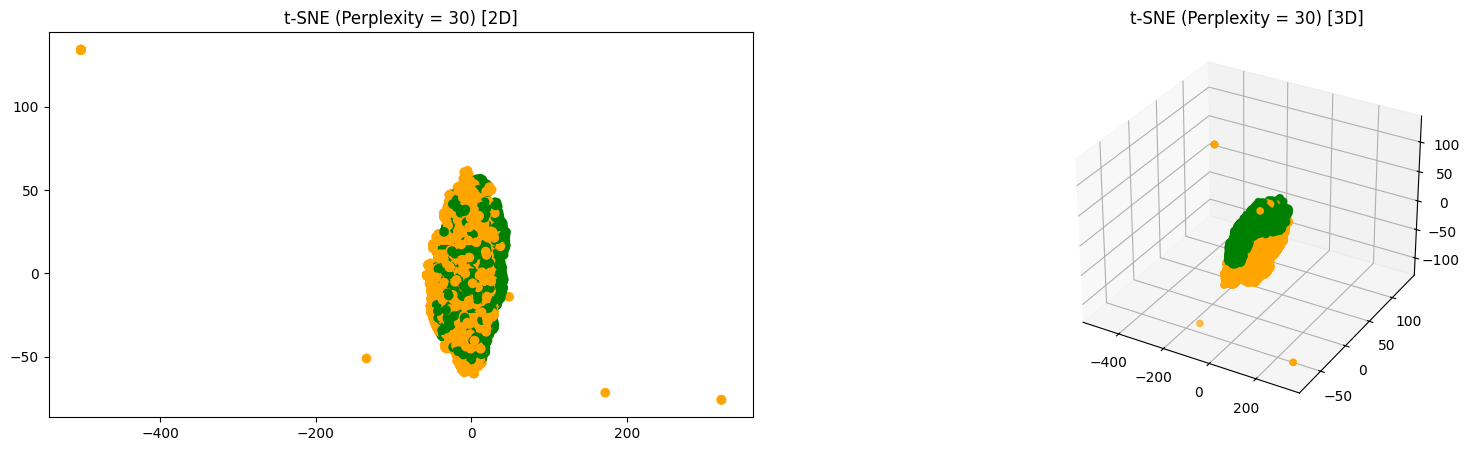

In [16]:
from sklearn.manifold import TSNE

# t-SNE (Perplexity set to 80)
t_sne_1 = TSNE(n_components=3, perplexity=80, init="pca", random_state=12345)
with timeit("t-SNE (Perplexity = 80)"):
    kdd_feat_t_sne_1 = t_sne_1.fit_transform(kdd_feat_std)

# t-SNE (Perplexity set to 40)
t_sne_2 = TSNE(n_components=3, init="pca", random_state=12345)
with timeit("t-SNE (Perplexity = 30)"):
    kdd_feat_t_sne_2 = t_sne_2.fit_transform(kdd_feat_std)

# Plot t-SNE result
visualize_samples(kdd_feat_t_sne_1, y_std, title="t-SNE (Perplexity = 80)")
visualize_samples(kdd_feat_t_sne_2, y_std, title="t-SNE (Perplexity = 30)")

## References

1. KDD Cup 1999 Dataset: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
2. Principal Component Analysis (PCA): https://en.wikipedia.org/wiki/Principal_component_analysis
3. Singular Value Decomposition (SVD): https://en.wikipedia.org/wiki/Singular_value_decomposition
4. Tutorial: Principal Components Analysis (PCA): https://lazyprogrammer.me/tutorial-principal-components-analysis-pca/
5. Kernel method: https://en.wikipedia.org/wiki/Kernel_method
6. Mercer's theorm: https://en.wikipedia.org/wiki/Mercer%27s_theorem
7. Kernel PCA: https://en.wikipedia.org/wiki/Kernel_principal_component_analysis
8. t-distributed Stochastic Neighbor Embedding (t-SNE): https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
9. StatQuest: t-SNE, Clearly Explained: https://www.youtube.com/watch?v=NEaUSP4YerM
10. Introduction to t-SNE: https://www.datacamp.com/community/tutorials/introduction-t-sne